In [13]:
import geopandas as gpd
import geoplot as gplt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [14]:
import warnings
warnings.filterwarnings('ignore')

## 1. Get Barrio shape and Population by using census data from Manzanas
- gdfFull: Full population file

In [15]:
bogotaG = gpd.read_file("../social_economic/population/barrios_pop_2011.geojson")
bogotaG = bogotaG[~bogotaG['geometry'].isnull()]
bogotaG = bogotaG.set_index('barriocomu')

dfCensoManz = pd.read_csv("../social_economic/population/TablaCensoManzanas.csv")
BarrioGp = pd.DataFrame(dfCensoManz.groupby(by='Barrio')['Poblacion'].sum())
gdfFull = pd.merge(bogotaG, BarrioGp, left_index=True, right_index=True, how='outer')

In [16]:
gdfFuller = gdfFull.fillna(0)
gdfFuller = gdfFuller[gdfFuller['Poblacion'] > 0]
gdfFuller = gdfFuller.reset_index()
print("The gdf gdfFuller has shape {}".format(gdfFuller.shape))

The gdf gdfFuller has shape (2992, 10)


In [19]:
## A barrio geopandas dataframe without filter, but hand crafted 
gdftopred = gdfFull[np.logical_or.reduce(
    (gdfFull['shape_area'] < 4e-4, gdfFull['Poblacion'] > 0)
) & (gdfFull['geometry'].centroid.y > 4.43)] 
print("The gdf gdftopred has shape {}".format(gdftopred.shape))

The gdf gdftopred has shape (3841, 9)


- gdfFuller: Barrios with population
- gdftopred: Barrios without holes

## 2. Creating Input to Kriging

In [20]:
dfKrigIn = pd.read_csv('KrigeIn/PM2.52017-2018.csv')
# dfKrigIn = dfKrigIn[(dfKrigIn['PM2.5'].apply(lambda x: x.isdigit()))]
print(dfKrigIn.shape)
dfKrigIn['Fecha'] = pd.to_datetime(dfKrigIn['Fecha'], format='%Y-%m-%d')
dfKrigIn['PM2.5'] = dfKrigIn['PM2.5'].astype('float64')

dfKrigIn['MnthYear'] = dfKrigIn['Fecha'].dt.strftime('%Y-%m')

(154044, 10)


In [21]:
serLst = list()
InGroups = dfKrigIn.groupby('Estacion')
for sta, stadf in InGroups:
    staMY = stadf.groupby('MnthYear')['PM2.5'].mean().rename(sta)
    staMY['lon'], staMY['lat'] = stadf['Longitud'].mean(), stadf['Latitud'].mean()
    serLst.append(staMY)

dfMnthYear = pd.concat(serLst,axis=1).T
dfMnthYear = dfMnthYear.rename({'Carvajal - Sevillana':'Carvajal'})
dfSta = dfMnthYear.rename({'MnthYear':"station"})
dfSta

MnthYear                      2017-01    2017-02    2017-03    2017-04  \
Carvajal                    24.088291  28.496429  29.315962  30.059634   
Centro de Alto Rendimiento  19.426279  23.689421  10.068421        NaN   
Guaymaral                   15.084770  23.042208  18.124661  17.246637   
Kennedy                     25.454142  34.314675  30.262376  27.129577   
Las Ferias                  18.585571  23.977454  22.173009  21.239405   
MinAmbiente                 16.802778  21.535232  24.315362  17.628407   
Puente Aranda               17.174234  23.718043  20.825907  20.518054   
San Cristobal               10.865625  16.063344  15.781169  12.518525   
Suba                        20.331536  25.650246  20.650273  21.641322   
Usaquen                     16.785381  22.439523  15.132308  15.696165   

MnthYear                      2017-05    2017-06    2017-07    2017-08  \
Carvajal                    26.597339  26.623662  24.106131  29.283062   
Centro de Alto Rendimiento        NaN        NaN   8.077990  11.283796   
Guaymaral                   10.860215  10.455859   6.736842  11.863201   
Kennedy                     24.585196  24.564636  18.751696  24.420118   
Las Ferias                  15.568120  14.057265  11.252905  12.861585   
MinAmbiente                 16.657817  12.754386   7.515000   9.589636   
Puente Aranda               17.803482  16.659634   9.847514  14.368826   
San Cristobal               11.011177   9.592030   7.095231   9.395742   
Suba                        16.865672  13.819364  11.075574  16.191633   
Usaquen                     12.897547  11.252319   7.803519   9.268608   

MnthYear                      2017-09    2017-10  ...    2018-05    2018-06  \
Carvajal                    29.022253  29.290000  ...  27.605547  28.771388   
Centro de Alto Rendimiento  14.081604  13.456874  ...  13.851711   7.437555   
Guaymaral                   14.407569  12.692427  ...   9.498418   8.049550   
Kennedy                     25.365527  26.375848  ...  21.383954  16.902684   
Las Ferias                  15.665113  15.500852  ...  14.029285   7.434023   
MinAmbiente                 12.772206  14.597997  ...  14.288646   8.067976   
Puente Aranda               15.465590  16.756118  ...  15.865897  10.966077   
San Cristobal               10.891433  13.663752  ...   8.580398   4.470479   
Suba                        17.752089  15.565217  ...  13.468665  11.822626   
Usaquen                     11.069527  11.875000  ...   9.491876   7.170015   

MnthYear                      2018-07    2018-08    2018-09    2018-10  \
Carvajal                    27.061821  30.654121  32.724332  26.733990   
Centro de Alto Rendimiento   7.966052   7.812840  13.856287  15.690815   
Guaymaral                    7.743434   8.598214  13.932409  16.075503   
Kennedy                     17.368630  19.922869  21.805564  22.731638   
Las Ferias                   7.933957   7.851304  14.808876  18.009269   
MinAmbiente                 10.907074   8.915447  14.567416  15.788632   
Puente Aranda               11.649431  10.366837  15.589944  18.289236   
San Cristobal                5.731175   4.928348   9.837178  13.284588   
Suba                         9.922961  10.526676  12.966006  14.135802   
Usaquen                      6.422662   6.216216  11.506329  14.764869   

MnthYear                      2018-11    2018-12        lon       lat  
Carvajal                    31.190273  31.499727 -74.148583  4.595629  
Centro de Alto Rendimiento  13.867452  11.287572 -74.083967  4.658479  
Guaymaral                   13.872340  13.599715 -74.043783  4.783746  
Kennedy                     24.840000  28.147018 -74.161333  4.625062  
Las Ferias                  18.051724  12.745377 -74.082483  4.690713  
MinAmbiente                 16.464441  11.930137 -74.066867  4.625562  
Puente Aranda               19.491499  18.875606 -74.117483  4.631779  
San Cristobal               13.633507   9.709537 -74.083800  4.572662  
Suba                        14.990726

In [22]:
from shapely.ops import triangulate

### 2.1 group station date into months then produce monthly station data

In [24]:
# isMultiPloy(egmul.buffer(-2e-3))
from tqdm import tqdm

In [35]:
from datetime import datetime as dt
import datetime

In [36]:
ymlst = dfSta.columns[:-2]
## Scale time to make gstat more stable 
def get_hrstr(somej, start = dt.strptime(ymlst[0],'%Y-%m'), delta = datetime.timedelta(hours=3)):
    return start+ delta*somej

In [37]:
DatMat =  [[[0] for i in range(4)] for j in range(234)] 
# np.zeros((234,4))

rawD = dfSta.drop(columns=['lat','lon']).values
stionLoc = dfSta[['lon','lat']].values
cvlst = list()

datcnt = 0
for i in range(rawD.shape[0]):
    stlst = []
    for j in range(rawD.shape[1]):
        # print(j)
        if np.isnan(rawD[i,j]):
            continue
        else:
            DatMat[datcnt][0] =  get_hrstr(j%12)  # ymlst[j] # j*0.01 + 50
            DatMat[datcnt][1:3] = stionLoc[i,:]
            DatMat[datcnt][3] = rawD[i,j]
            # print(rawD[i,j])
            stlst.append(datcnt)
            datcnt += 1
    cvlst.append(stlst)

In [38]:
dfston = pd.DataFrame(DatMat)
# dfston[3].value_counts().sort_index()

In [39]:
pd.DataFrame(DatMat).to_csv('KrigeIn/stonYM.csv', index=False, header=False)

### 2.2 output to predict data

In [40]:
## Assign a center to each polygon used in prediction 
## Non convex polygons will have a
def proj_centr_in(polygon):
    polycent = polygon.centroid
    if polygon.contains(polycent):
        return polycent
    else:
        min_dis, mincent = np.inf, False
        for trgle in triangulate(polygon):
            if trgle.within(polygon):
                trgcent = trgle.centroid
                thisDis = polycent.distance(trgcent)
                if thisDis < min_dis:
                    min_dis, mincent = thisDis, trgcent

        if not mincent:
            print("Exception occuring")
            return polycent
        
        return mincent 

In [41]:
all_cent = list()
for poly in tqdm(gdfFuller['geometry']):
    ctr = poly.centroid
    if poly.contains(ctr):
        all_cent.append(ctr)
    else:
        all_cent.append(proj_centr_in(poly))

100%|██████████| 2992/2992 [00:02<00:00, 1270.80it/s]


In [42]:
## More generic cases:
ful_cent = list()
for poly in tqdm(gdftopred['geometry']):
    ctr = poly.centroid
    if poly.contains(ctr):
        ful_cent.append(ctr)
    else:
        ful_cent.append(proj_centr_in(poly))

100%|██████████| 3841/3841 [00:02<00:00, 1355.45it/s] 


In [43]:
iterDic = dict()

idx = 0 
for i in tqdm(range(len(ymlst))):
    tmK = get_hrstr(i)
    for ct in ful_cent:
        tmpDic = dict()
        tmpDic['lat'], tmpDic['lon'] = ct.y, ct.x # barLat[j], barLon[j]
        tmpDic['date'], tmpDic['pred'] = tmK, np.nan
        iterDic[idx] = tmpDic
        idx += 1

100%|██████████| 24/24 [00:01<00:00, 16.35it/s]


In [44]:
(pd.DataFrame(iterDic).T).to_csv("KrigeIn/toPredYM_ful.csv", index=False, header=False)

## 3 Load Prediction

In [45]:
from shapely.geometry import Point, Polygon, MultiPolygon
from scipy import interpolate

In [46]:
# dfRPred = pd.read_csv("../Data/rpreded.csv")
dfRPred = pd.read_csv("KrigeOut/prd_ful.csv")
dfRPred = dfRPred.drop(columns=['Unnamed: 0'])

In [48]:
gdfRPred = gpd.GeoDataFrame(data=dfRPred, geometry= gpd.points_from_xy(dfRPred['V2'], dfRPred['V1']))
# gdfRPred.head()

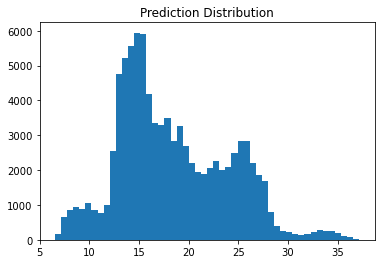

In [49]:
# import geoplot
# import geoplot.crs as gcrs
plt.title("Prediction Distribution")
plt.hist(gdfRPred['V4'], bins=50)
plt.show()

In [52]:
grps = gdfRPred.groupby(by=['V1','V2'])
# grps = gdfRPred.groupby(by='geometry')
mnsrs = grps['V4'].mean()
gdfPs = gpd.GeoDataFrame(mnsrs)
gdfPs = gdfPs.reset_index()

In [53]:
gdfPs[gdfPs.isnull().any(axis=1)]

Empty DataFrame
Columns: [V1, V2, V4]
Index: []

In [54]:
gdfPs['geometry'] = gdfPs.apply( lambda x: Point(x['V2'], x['V1']), axis=1)

<AxesSubplot:title={'center':'Prediction Point Plot'}>

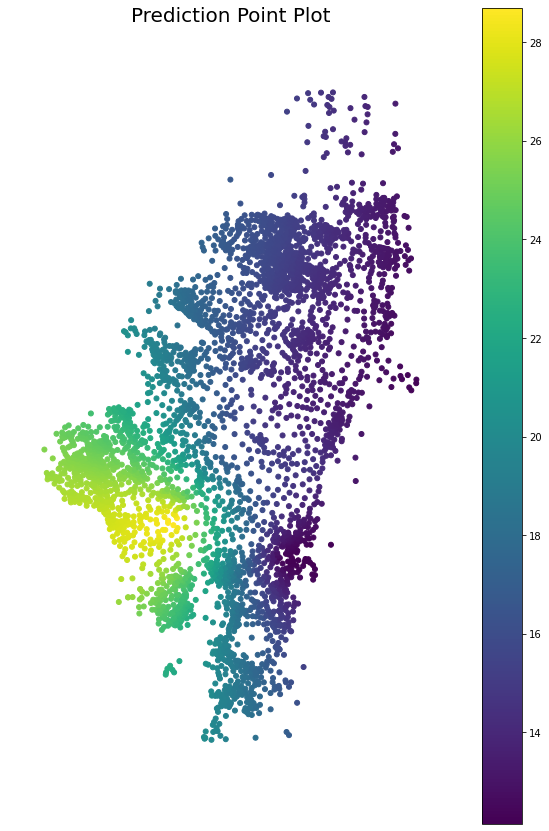

In [57]:
fig, ax = plt.subplots(figsize=(10,15))

ax.set_title("Prediction Point Plot", fontsize=20)
gplt.pointplot(
    gdfPs,
    hue='V4',
    legend=True,
    ax=ax)

In [40]:
# gdfFuller

In [45]:
points = [2.1, 3.1, 3.02]

def opball_dis(points_withindf, epsl, trgs):
    points_sorted = points_withindf.sort_values(by='V4')
    last_v = points_sorted.iloc[0]['V4']

    actv_plst, actv_vlst = list(), list()
    poly_vlst = list()
    for idx, p_df in points_sorted.iterrows():
        this_v = p_df['V4']
        if (this_v - last_v < epsl):
            trgcontaining = [trgi for trgi in trgs if trgi.contains(p_df['geometry'])]
            for trgi in trgcontaining:
                thexy = trgi.exterior.coords.xy
                # print(list(zip(thexy[0],thexy[1])))
                actv_plst += list(zip(thexy[0],thexy[1]))
            actv_vlst.append(this_v)
        else:
            # print(actv_plst)
            poly_vlst.append(
                (Polygon(actv_plst).convex_hull, mean(actv_vlst))
            )
            actv_plst, actv_vlst = list(), list()
            trgcontaining = [trgi for trgi in trgs if trgi.contains(p_df['geometry'])]
            for trgi in trgcontaining:
                thexy = trgi.exterior.coords.xy
                actv_plst += list(zip(thexy[0],thexy[1]))
            actv_vlst.append(this_v)
    return poly_vlst        

In [59]:
gdfFuller = gdfFuller.reset_index()
gdfFuller['predR'] = np.nan

In [60]:
# pass_idx = list()
gdfFuller[gdfFuller['index'] == 'Santa Marta']
gdfFuller = gdfFuller[~gdfFuller['estado'].isna()]
gdfFuller

level_0                             index  shape_area  objectid  \
0           0                   11 de Noviembre    0.000011      3248   
1           1                     12 de Octubre    0.000029      3300   
2           2                    5 de Noviembre    0.000001      3857   
3           3                    8 de Diciembre    0.000002      1499   
4           4                   Abraham Lincoln    0.000016      3359   
...       ...                               ...         ...       ...   
2987     2987                   Zona Industrial    0.000032      3388   
2988     2988                             Zulia    0.000001      2145   
2989     2989                      Álamos Norte    0.000022       384   
2990     2990  Álamos Norte Sector Nor-Oriental    0.000009       549   
2991     2991              Álvaro Bernal Segura    0.000004      1461   

      shape_len       localidad         estado  cod_loc  cod_polbar  \
0      0.013893  Barrios Unidos     LEGALIZADO       12      120066   
1      0.029429  Barrios Unidos     LEGALIZADO       12      120007   
2      0.005083  Antonio Nariño  SIN LEGALIZAR       15      150027   
3      0.007972  Ciudad Bolívar     LEGALIZADO       19      190141   
4      0.018827      Tunjuelito     LEGALIZADO        6       60001   
...         ...             ...            ...      ...         ...   
2987   0.028312      Tunjuelito  SIN LEGALIZAR        6       60035   
2988   0.005654               0  SIN LEGALIZAR       11      110823   
2989   0.022045        Engativá     LEGALIZADO       10      100004   
2990   0.017784        Engativá  SIN LEGALIZAR       10      100005   
2991   0.016660  Ciudad Bolívar     LEGALIZADO       19      190006   

                                               geometry  Poblacion  predR  
0     POLYGON ((-74.07337 4.66773, -74.07260 4.66863...     3286.0    NaN  
1     MULTIPOLYGON (((-74.07071 4.67082, -74.07153 4...     6300.0    NaN  
2     POLYGON ((-74.12663 4.59172, -74.12660 4.59178...     1462.0    NaN  
3     POLYGON ((-74.14923 4.53850, -74.14922 4.53849...      840.0    NaN  
4     POLYGON ((-74.12416 4.56071, -74.12404 4.56044...     6282.0    NaN  
...                                                 ...        ...    ...  
2987  POLYGON ((-74.14639 4.59492, -74.14634 4.59491...       20.0    NaN  
2988  POLYGON ((-74.09587 4.74284, -74.09610 4.74240...     1646.0    NaN  
2989  POLYGON ((-74.11822 4.70698, -74.11815 4.70692...     7183.0    NaN  
2990  POLYGON ((-74.11147 4.70449, -74.11150 4.70445...     2785.0    NaN  
2991  POLYGON ((-74.14465 4.54871, -74.14466 4.54871...     2006.0    NaN  

[2992 rows x 12 columns]

In [61]:
gdfFull = gdfFull.reset_index()

In [63]:
## Assign Predictions
for idx,rw in tqdm(gdftopred.iterrows()):
    pts_wthin = gdfPs[gdfPs['geometry'].within(rw['geometry'])]
    gdftopred.loc[idx,'predR'] = pts_wthin['V4'].mean()

3841it [00:31, 122.16it/s]


In [64]:
## Assign Predctions
for idx,rw in tqdm(gdfFuller.iterrows()):
    pts_wthin = gdfPs[gdfPs['geometry'].within(rw['geometry'])]
    gdfFuller.loc[idx,'predR'] = pts_wthin['V4'].mean()

2992it [00:24, 120.99it/s]


In [69]:
gdfFuller.to_file("gdf_barrio.json",driver='GeoJSON')
# .iloc[1883+26+979:]

In [65]:
from statistics import mean
def give_intrg(polygon):
    return [triangle for triangle in triangulate(polygon) if triangle.within(polygon)]

In [67]:
# gdfFuller[gdfFuller['predR'].isna()]
gdftopred.head()

index    shape_area  objectid  shape_len  \
0           11 de Noviembre  1.077889e-05      3248   0.013893   
1             12 de Octubre  2.891958e-05      3300   0.029429   
2  12 de Octubre - Alcabaza  3.320279e-07      2564   0.002823   
3            5 de Noviembre  1.229473e-06      3857   0.005083   
4            8 de Diciembre  2.344792e-06      1499   0.007972   

        localidad         estado  cod_loc  cod_polbar  \
0  Barrios Unidos     LEGALIZADO       12      120066   
1  Barrios Unidos     LEGALIZADO       12      120007   
2  Barrios Unidos  SIN LEGALIZAR       12      120008   
3  Antonio Nariño  SIN LEGALIZAR       15      150027   
4  Ciudad Bolívar     LEGALIZADO       19      190141   

                                            geometry  Poblacion      predR  
0  POLYGON ((-74.07337 4.66773, -74.07260 4.66863...     3286.0  13.725835  
1  MULTIPOLYGON (((-74.07071 4.67082, -74.07153 4...     6300.0  13.833359  
2  POLYGON ((-74.07576 4.67170, -74.07575 4.67171...        NaN  13.891630  
3  POLYGON ((-74.12663 4.59172, -74.12660 4.59178...     1462.0  23.394496  
4  POLYGON ((-74.14923 4.53850, -74.14922 4.53849...      840.0  24.090378

<AxesSubplot:>

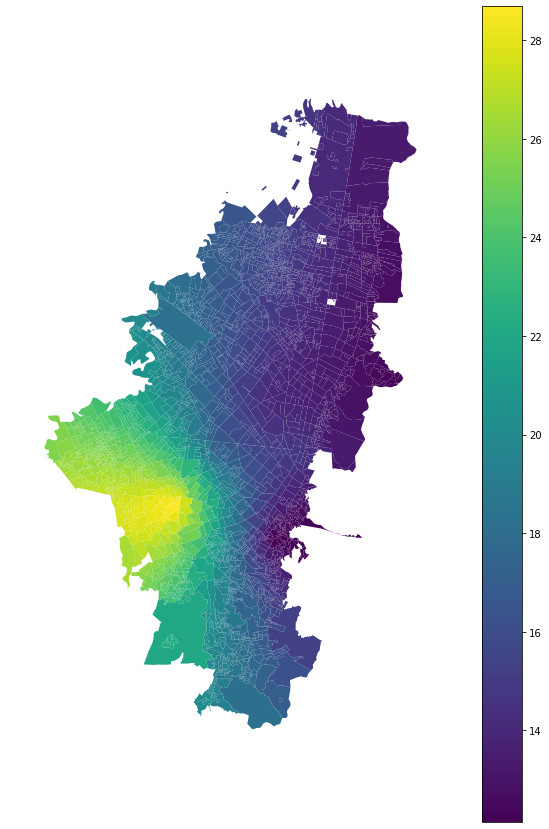

In [68]:
fig, ax = plt.subplots(figsize= (10,15))

gplt.choropleth(
    gdftopred,
    hue='predR',
    cmap='viridis',
    legend=True,
    edgecolor='None',
    ax=ax
)

In [65]:
gdftopred.to_file('KrigeOut/barrio_pred.geojson', driver="GeoJSON")

In [249]:
fig.savefig("../plotImage/2dkriging.pdf")

In [62]:
def close_holes(poly: Polygon) -> Polygon:
    """
    Close polygon holes by limitation to the exterior ring.
    Args:
        poly: Input shapely Polygon
    Example:
        df.geometry.apply(lambda p: close_holes(p))
    """
    if isMultiPloy(poly):
        return MultiPolygon(Polygon(p.exterior) for p in poly)
    if poly.interiors:
        return Polygon(list(poly.exterior.coords))
    else:
        return poly

In [64]:
import matplotlib.pyplot as plt

In [65]:
# gdftopred['geometry'] = gdftopred['geometry'].apply(close_holes)
import matplotlib.cm as cm

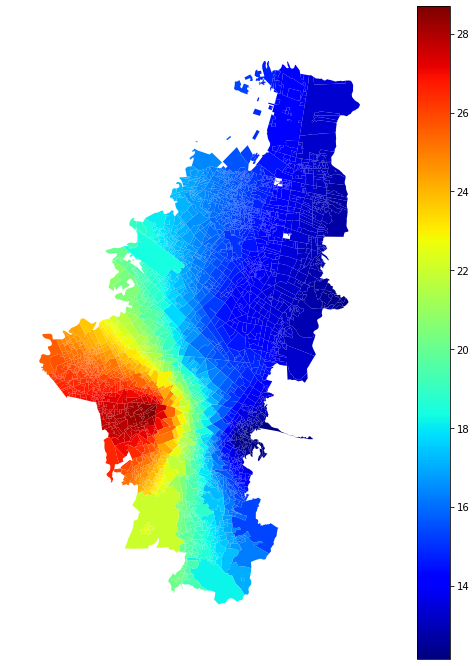

In [66]:
fig, ax = plt.subplots(figsize= (9,12))

gplt.choropleth(
    gdftopred,
    hue='predR',
    cmap=cm.jet,
    legend=True,
    edgecolor='None',
    ax=ax
)

fig.savefig('../plot/2dkrig_full.pdf')

In [188]:
gdfFuller.loc['Santa Marta']

shape_area  objectid  shape_len localidad         estado  \
Santa Marta    0.000005      1288   0.010947   Kennedy           URBA   
Santa Marta    0.000008      2984   0.012593      Usme  SIN LEGALIZAR   

             cod_loc  cod_polbar  \
Santa Marta        8       80342   
Santa Marta        5       50256   

                                                      geometry  Poblacion  \
Santa Marta  POLYGON ((-74.16772 4.64734, -74.16886 4.64639...       18.0   
Santa Marta  POLYGON ((-74.10001 4.50859, -74.09998 4.50831...       18.0   

                 predR  
Santa Marta  17.199512  
Santa Marta  17.199512

In [69]:
gdfFuller['xlat'], gdfFuller['ylon'] = gdfFuller.centroid.x, gdfFuller.centroid.y

In [70]:
gdftopred['xlat'], gdftopred['ylon'] = gdftopred.centroid.x, gdftopred.centroid.y

In [81]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [82]:
sclr = MinMaxScaler()
tkm = sclr.fit_transform(gdfFuller[['xlat', 'ylon', 'predR']])
kmlbl = KMeans(n_clusters=3,random_state=6897278, max_iter=800).fit_predict(tkm)
gdfFuller['3meanslabl'] = kmlbl

In [83]:
sclr = MinMaxScaler()
tkm = sclr.fit_transform(gdftopred[['xlat', 'ylon', 'predR']])
kmlbl = KMeans(n_clusters=3,random_state=6897278, max_iter=800).fit_predict(tkm)
gdftopred['3meanslabl'] = kmlbl

In [75]:
from shapely.geometry import Point
from tqdm import tqdm


def addpolygonax(ax,polygon,colobj):
    x,y = polygon.exterior.coords.xy
    z = np.full(len(x), 0)
    # np.zeros(len(x))
    verts = [list(zip(x,y,z))]
    # print(verts)
    instploy = Poly3DCollection(verts)
    instploy.set_color(colobj)
    # instploy.set_edgecolor("white")
    ax.add_collection3d(instploy)
    return ax

def map_colors(p3dc, func= lambda x, y , z : z, cmap='Spectral'):
    """
Color a tri-mesh according to a function evaluated in each barycentre.

    p3dc: a Poly3DCollection, as returned e.g. by ax.plot_trisurf
    func: a single-valued function of 3 arrays: x, y, z
    cmap: a colormap NAME, as a string

    Returns a ScalarMappable that can be used to instantiate a colorbar.
    """
    
    from matplotlib.cm import ScalarMappable, get_cmap
    from matplotlib.colors import Normalize
    from numpy import array

    # reconstruct the triangles from internal data
    x, y, z, _ = p3dc._vec
    slices = p3dc._segslices
    print(len(slices))
    triangles = array([array((x[s],y[s],z[s])).T for s in slices])

    # compute the barycentres for each triangle
    xb, yb, zb = triangles.mean(axis=1).T
    
    # compute the function in the barycentres
    values = func(xb,yb,zb)
    print(len(values))

    # usual stuff
    norm = Normalize()
    colors = get_cmap(cmap)(norm(values))

    # set the face colors of the Poly3DCollection
    p3dc.set_fc(colors)

    # if the caller wants a colorbar, they need this
    return ScalarMappable(cmap=cmap, norm=norm)

def map_klbl(xb,yb,zb,df = gdfFuller):
    # print(x)
    # print((df['barox'] == x))
    # print((df['baroy'] == y))
    # return np.digitize(zb, bins)
    retls = list()
    for lati, loni in tqdm(zip(xb,yb)):
        if len(df[df['cvxh'].contains(Point(lati,loni))]['3meanslabl']) == 0:
            retls.append(1)
        else:
            thelbel = df[df['cvxh'].contains(Point(lati,loni))]['3meanslabl'][0]
            retls.append(thelbel)
    return np.array(retls)

In [256]:
gdfFuller.to_csv('../Data/BestAfterValidationKrig.csv')

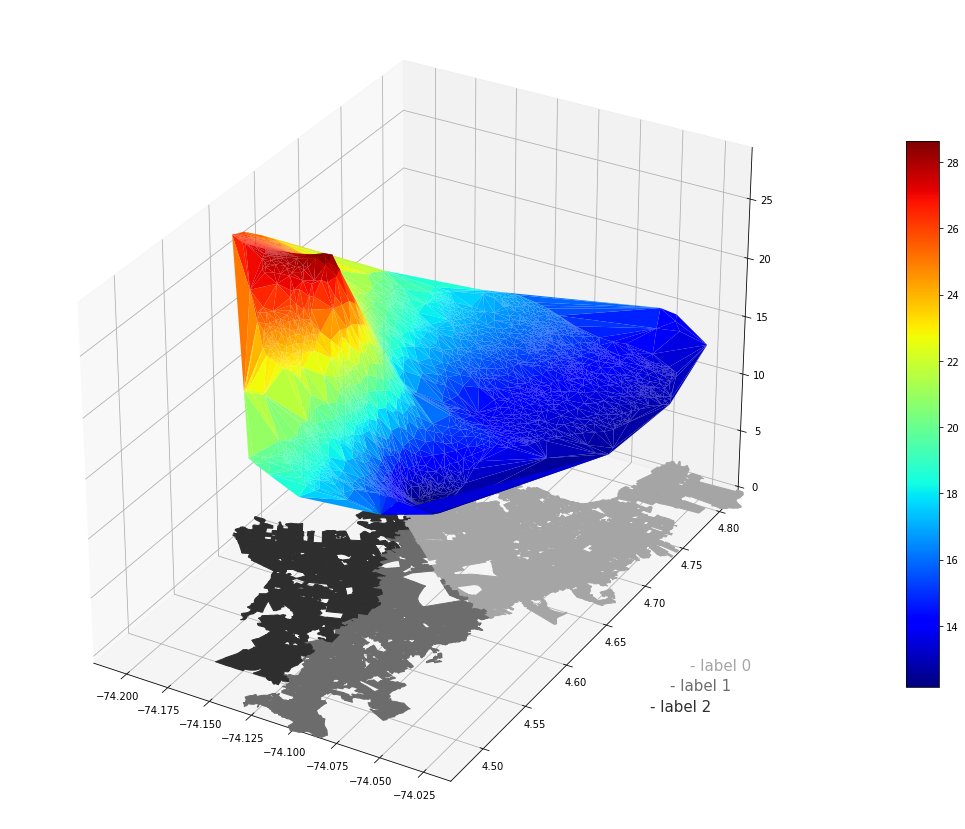

In [86]:
fig = plt.figure(figsize=(30,15))
# ax = Axes3D(fig, auto_add_to_figure=False)
ax = fig.gca(projection='3d')
ax.set_xlim3d(gdfFuller['xlat'].min(), gdfFuller['xlat'].max())
ax.set_ylim3d(gdfFuller['ylon'].min(),gdfFuller['ylon'].max())
# ax.set_zlim3d(-12,5)
# PM2normer = Normalize(vmin=gdfFuller['3meanslabl'].min(), vmax=gdfFuller['3meanslabl'].max())
mapper = {0:0.45,1:0.65,2:0.85}
def PM2normer(labl, mapper =mapper):
    return mapper[labl]
cmap = plt.cm.Greys

gdfplt = gdfFuller.explode()

for baro, rwbaro in gdfplt.iterrows():
    # klb = 
    # print(rwbaro['3meanslabl'])
    c = cmap(PM2normer(rwbaro['3meanslabl']))
    # print(c)
    # print(rwbaro['geometry'])
    ax = addpolygonax(ax,rwbaro['geometry'],c)

# addpolygonax(ax,poly,0.7)

## Try and strech the z axis:
ax.set_box_aspect(aspect = (1,1.5,1))

X, Y = (gdfFuller['xlat'], gdfFuller['ylon'])
Z = gdfFuller['predR'] + 0


# fig = plt.figure()
# ax = Axes3D(fig)
surf = ax.plot_trisurf(X, Y, Z,cmap=plt.cm.jet, linewidth=0.1)

# possibly add a colormap
plt.colorbar(surf, shrink=0.67, aspect=16.7)

# fig.colorbar(surf, shrink=0.5, aspect=5)
# plt.savefig('teste.pdf')
xalign, yalign, fntsize =  -73.95,4.60, 15
ax.text(xalign,yalign+0.025,0,"- label 0", color = cmap(mapper[0]), fontsize=fntsize)
ax.text(xalign,yalign,0,"- label 1", color = cmap(mapper[1]), fontsize=fntsize)
ax.text(xalign,yalign-0.025,0, "- label 2", color = cmap(mapper[2]), fontsize=fntsize)

plt.show()
fig.savefig("../plot/hole_surface.pdf")

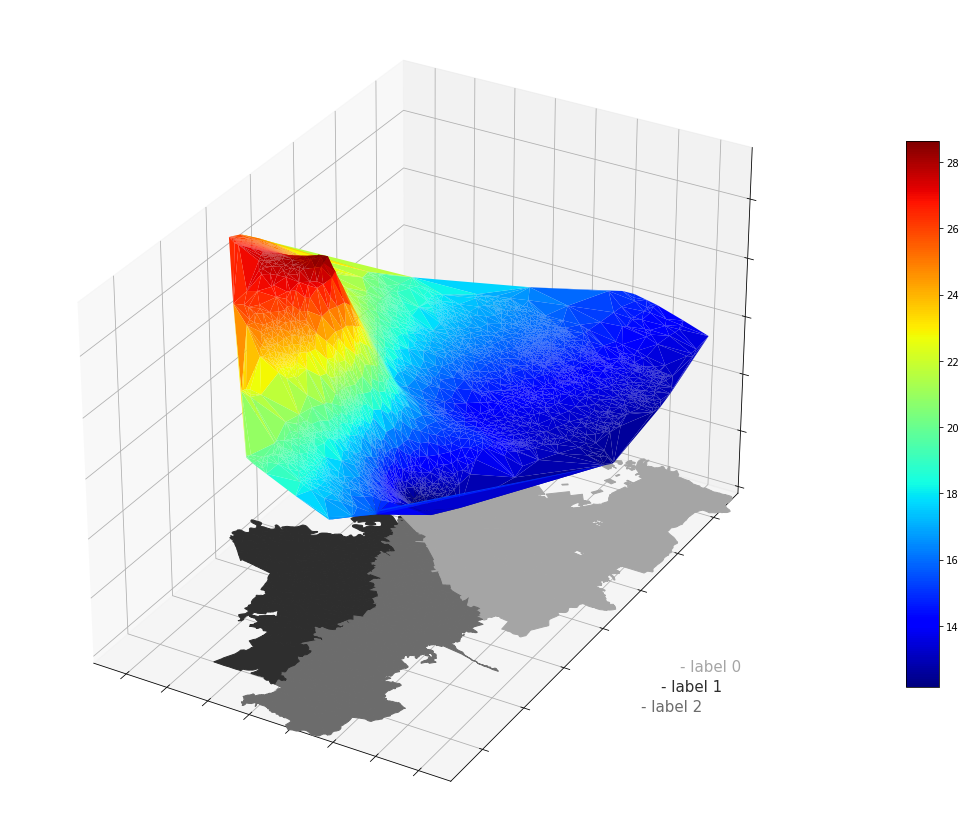

In [89]:
fig = plt.figure(figsize=(30,15))
# ax = Axes3D(fig, auto_add_to_figure=False)
ax = fig.gca(projection='3d')
# ax.set_axis_off()

ax.set_xlim3d(gdftopred['xlat'].min(), gdftopred['xlat'].max())
ax.set_ylim3d(gdftopred['ylon'].min(),gdftopred['ylon'].max())

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
# ax.set_zlim3d(-12,5)
# PM2normer = Normalize(vmin=gdfFuller['3meanslabl'].min(), vmax=gdfFuller['3meanslabl'].max())
mapper = {0:0.45,1:0.85,2:0.65}
def PM2normer(labl, mapper =mapper):
    return mapper[labl]
cmap = plt.cm.Greys

gdfplt = gdftopred.explode()

for baro, rwbaro in gdfplt.iterrows():
    # klb = 
    # print(rwbaro['3meanslabl'])
    c = cmap(PM2normer(rwbaro['3meanslabl']))
    # print(c)
    # print(rwbaro['geometry'])
    ax = addpolygonax(ax,rwbaro['geometry'],c)

# addpolygonax(ax,poly,0.7)

## Try and strech the z axis:
ax.set_box_aspect(aspect = (1,1.5,1))

# Z = gdfPs['V4'] + 0
X, Y = (gdftopred['xlat'], gdftopred['ylon'])
Z = gdftopred['predR'] + 0


# fig = plt.figure()
# ax = Axes3D(fig)
surf = ax.plot_trisurf(X, Y, Z,cmap=plt.cm.jet, linewidth=0.1)

# possibly add a colormap
plt.colorbar(surf, shrink=0.67, aspect=16.7)

# fig.colorbar(surf, shrink=0.5, aspect=5)
# plt.savefig('teste.pdf')
xalign, yalign, fntsize =  -73.95,4.60, 15
ax.text(xalign,yalign+0.025,0,"- label 0", color = cmap(mapper[0]), fontsize=fntsize)
ax.text(xalign,yalign,0,"- label 1", color = cmap(mapper[1]), fontsize=fntsize)
ax.text(xalign,yalign-0.025,0, "- label 2", color = cmap(mapper[2]), fontsize=fntsize)

plt.show()
fig.savefig("../plot/surface_krig_full.pdf")